In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# Too flexible structure, but will do
FILES = {
    'stopped_car': {
        'sensor_layer': {
            'general': './stopped_car/sensor_layer/general.csv'
        },
        'fusion_layer': {
            'temporal_alignment': './stopped_car/fusion_layer/temporal_alignment.csv',
            'no_temporal_alignment': './stopped_car/fusion_layer/no_temporal_alignment.csv',
        },
        'application_layer': {
            'temporal_alignment': './stopped_car/application_layer/temporal_alignment.csv',
            'no_temporal_alignment': './stopped_car/application_layer/no_temporal_alignment.csv',
        },
    },
    'both_moving': {
        'sensor_layer': {
            'general': './both_moving//sensor_layer/general.csv'
        },
        'fusion_layer': {
            'temporal_alignment': './both_moving/fusion_layer/temporal_alignment.csv',
            'no_temporal_alignment': './both_moving/fusion_layer/no_temporal_alignment.csv',
        },
        'application_layer': {
            'temporal_alignment': './both_moving/application_layer/temporal_alignment.csv',
            'no_temporal_alignment': './both_moving/application_layer/no_temporal_alignment.csv',
        },
    }
}

EXPERIMENT_NAME = 'both_moving'  # Changing experiment here
EXPERIMENT_VARIATION = 'temporal_alignment'
EXPERIMENT_FILES = FILES[EXPERIMENT_NAME]

In [2]:
sensor_df_file = EXPERIMENT_FILES['sensor_layer']['general']
sensor_df = pd.read_csv(
    sensor_df_file,
    names=['timestamp', 'sensor_name', 'n_objects', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'yaw', 'yaw_rate']
)

print('Sensor DF first measurement:', sensor_df['timestamp'].min())

sensor_df['timestamp'] = (sensor_df['timestamp'] - sensor_df['timestamp'].min()) / 10**9
sensor_df1 = sensor_df[sensor_df.sensor_name == 'sensor1']

sensor_df1.head()

Sensor DF first measurement: 1621242623651325792


,timestamp,sensor_name,n_objects,x,y,vx,vy,ax,ay,yaw,yaw_rate
0,0.000000,sensor1,1,-148.99478,-80.58735,0.03294,0.47233,0.06468,0.64271,-1.56875,0.02048
2,0.096150,sensor1,1,-148.99228,-80.54408,0.03745,0.53739,0.05280,0.76231,-1.56715,0.01671
4,0.192271,sensor1,1,-148.98721,-80.49280,0.09027,0.65453,0.62016,1.37526,-1.56371,0.05073
6,0.272085,sensor1,1,-148.98506,-80.42434,0.00747,0.79668,-0.87820,1.50777,-1.56286,0.00264
8,0.352307,sensor1,1,-148.98442,-80.35335,0.00725,0.93399,-0.00275,1.68477,-1.56294,-0.00266


In [3]:
def obj_to_almost_relative(fusion_df, sensor_df):
    # Almost because don't transform all the elements, only the used in this notebook
    # Could have been used the transformation matrix, but this will also do
    
    angles = sensor_df['yaw'].copy()

    cos_angles = np.cos(angles)
    sin_angles = np.sin(angles)

    # Transforming back to CARLA reference frame
    tmp_df = fusion_df.copy()
    tmp_df['x'] = fusion_df['x']*cos_angles - fusion_df['y']*sin_angles
    tmp_df['y'] = fusion_df['x']*sin_angles + fusion_df['y']*cos_angles
    
    tmp_df['vx'] = fusion_df['vx']*cos_angles - fusion_df['vy']*sin_angles
    tmp_df['vy'] = fusion_df['vx']*sin_angles + fusion_df['vy']*cos_angles
    
    tmp_df['y'] = -tmp_df['y']
    tmp_df['vy'] = -tmp_df['vy']
    
    tmp_df[['x', 'y', 'vx', 'vy']] += sensor_df[['x', 'y', 'vx', 'vy']]
    
    return tmp_df

def is_obj_stopped(absolute_obj_pos_df):
    displacement_x = (absolute_obj_pos_df['x'].iloc[0] - absolute_obj_pos_df['x'].iloc[-1])
    displacement_y = (absolute_obj_pos_df['y'].iloc[0] - absolute_obj_pos_df['y'].iloc[-1])

    return (abs(displacement_x) + abs(displacement_y)) <= 1

In [4]:
fusion_df_file = EXPERIMENT_FILES['fusion_layer'][EXPERIMENT_VARIATION]
fusion_df = pd.read_csv(
    fusion_df_file,
    names=['timestamp', 'sensor_name', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'yaw', 'yaw_rate', 'idx_to_associate', 'association_score', 'association_failed']
)

print('Fusion DF first measurement:', fusion_df['timestamp'].min())

fusion_df['timestamp'] = (fusion_df['timestamp'] - fusion_df['timestamp'].min()) / 10**9
fusion_df1 = fusion_df[fusion_df.sensor_name == 'sensor1']

fusion_df1.head()

Fusion DF first measurement: 1621242623651325792


,timestamp,sensor_name,x,y,vx,vy,ax,ay,yaw,yaw_rate,idx_to_associate,association_score,association_failed
0,0.000000,sensor1,12.32606,0.85077,3.11015,-0.43930,2.56292,-0.74795,-0.06124,-0.13004,0,0.500,1
2,0.096150,sensor1,12.60301,0.79516,3.31587,-0.49978,2.41863,-0.65037,-0.07205,-0.12617,0,0.908,0
4,0.192271,sensor1,12.89532,0.70732,3.46177,-0.63282,1.73338,-1.42841,-0.08512,-0.16696,0,0.889,0
6,0.272085,sensor1,13.23115,0.64404,3.61073,-0.61901,1.58569,0.17800,-0.09663,-0.11676,0,0.863,0
8,0.352307,sensor1,13.53074,0.59538,3.71657,-0.69305,1.29803,-0.91227,-0.10609,-0.11693,0,0.920,0


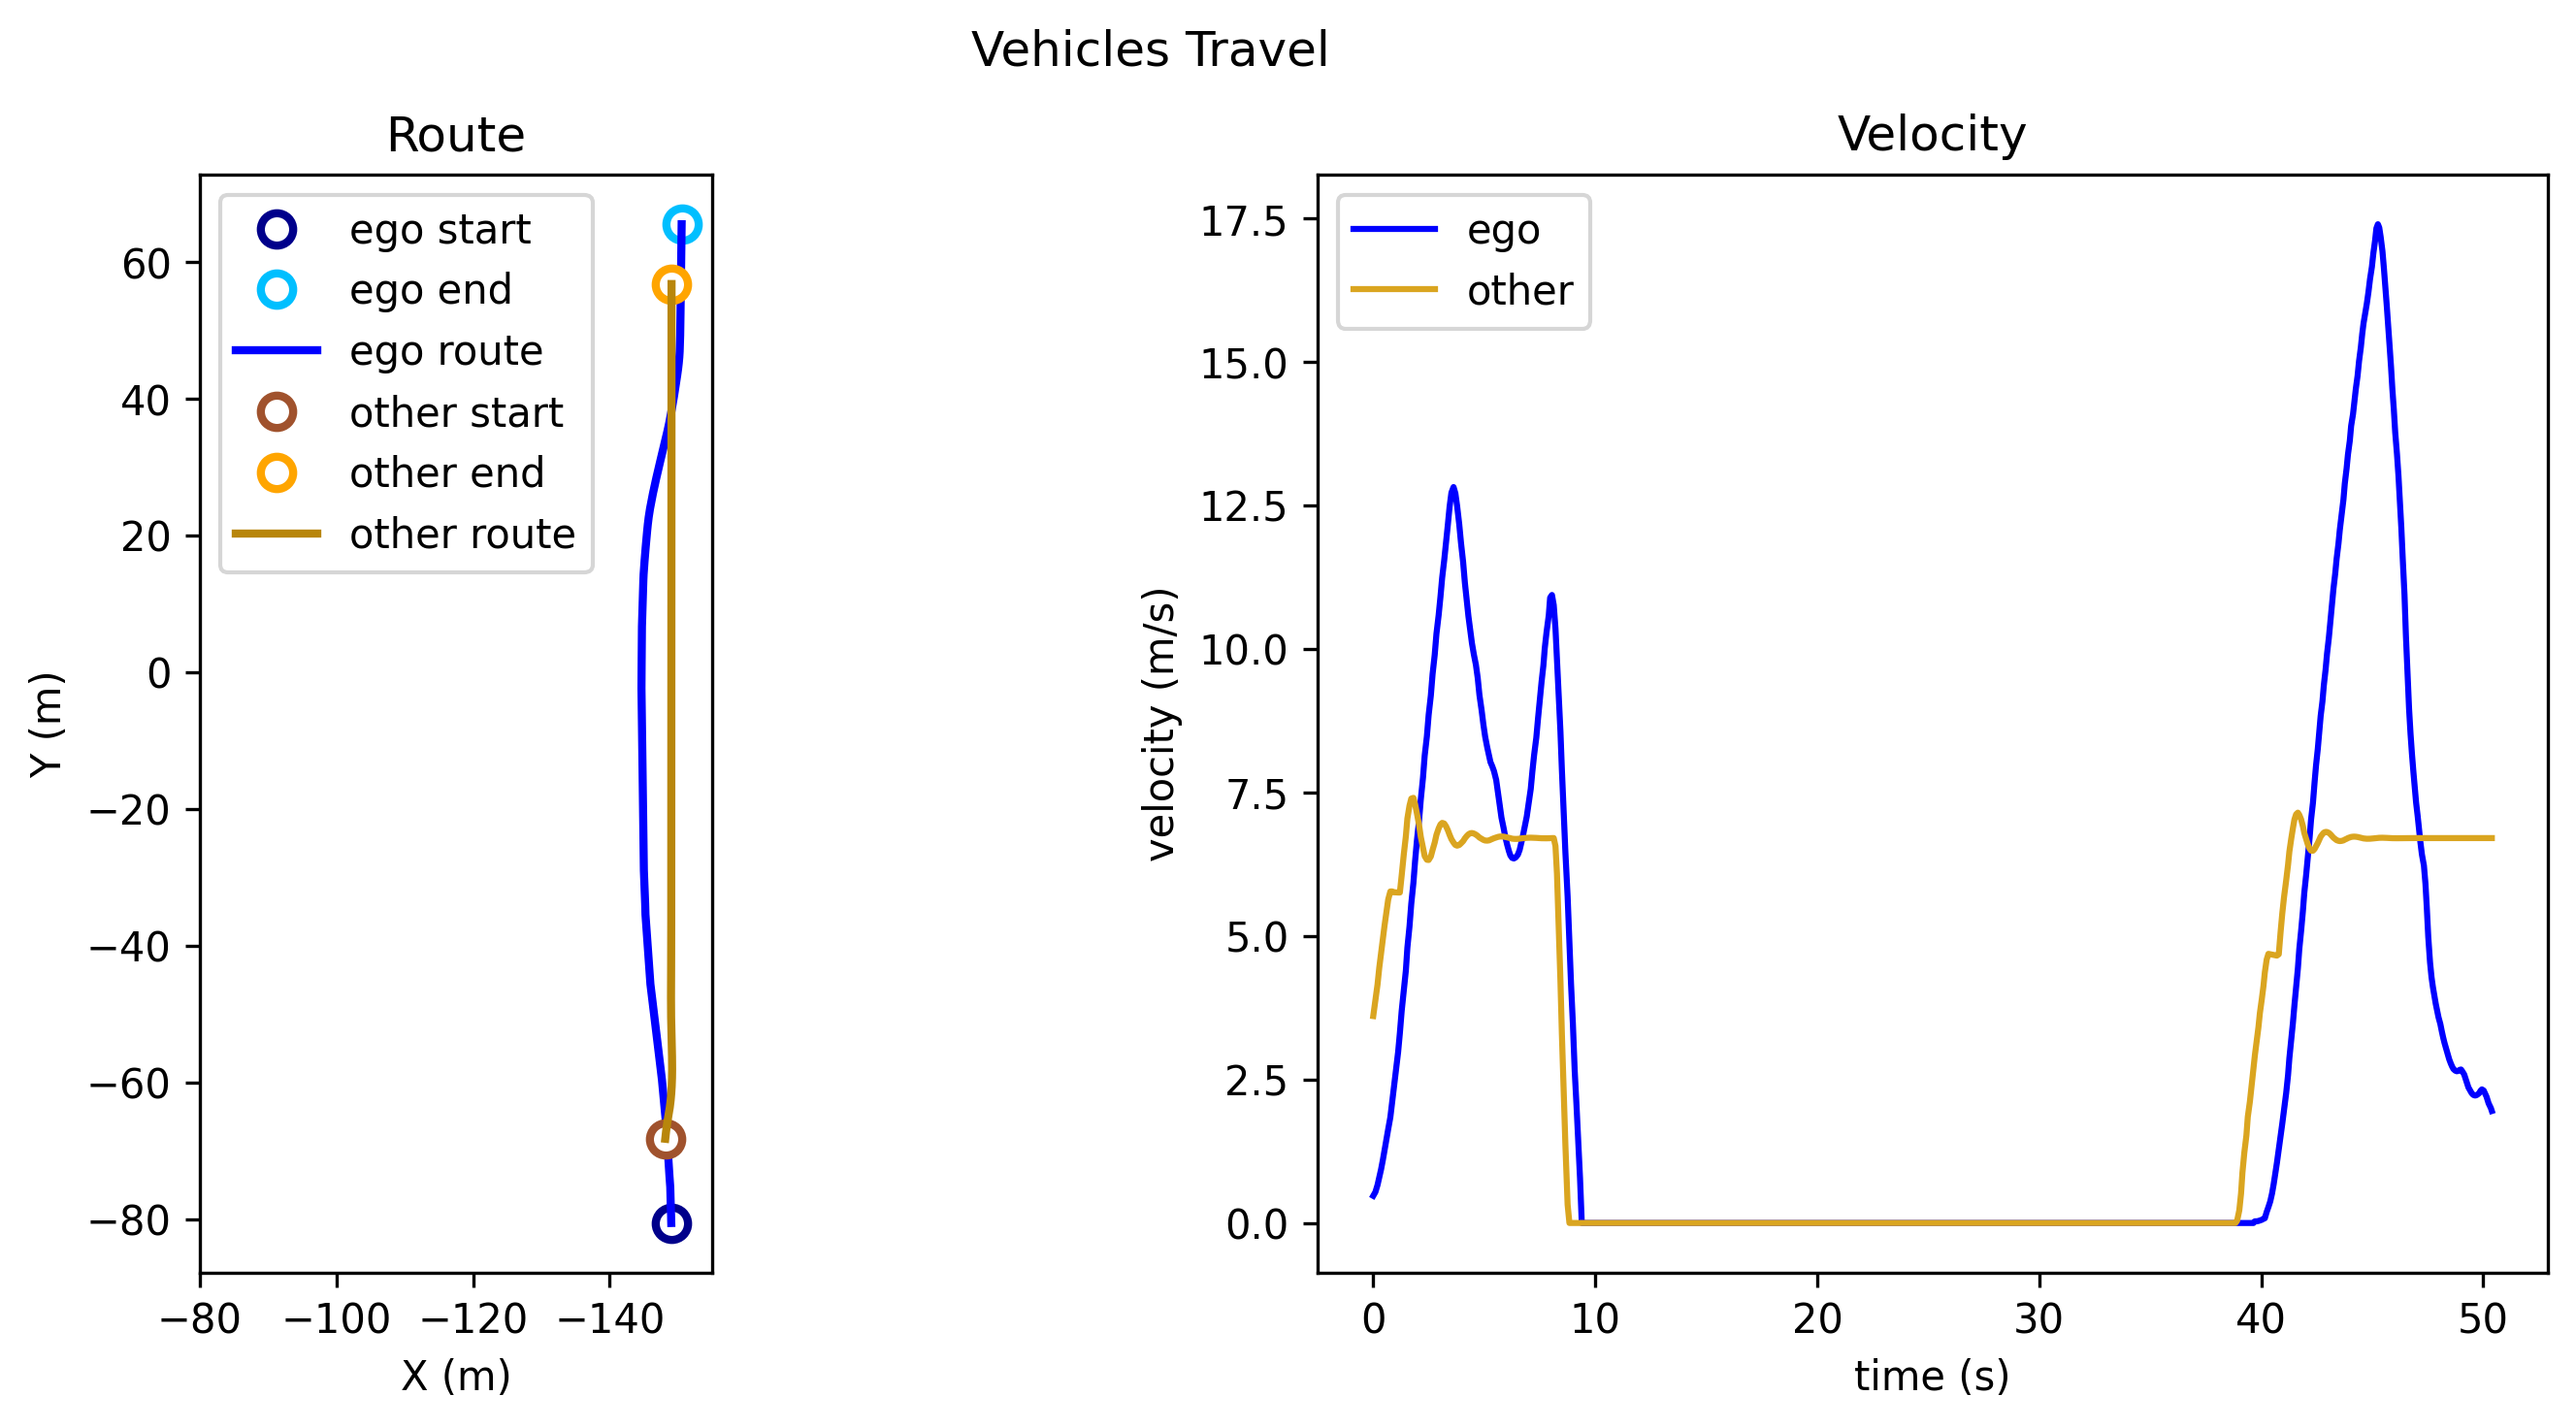

In [5]:
absolute_obj_df1 = obj_to_almost_relative(fusion_df1, sensor_df)

fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(12, 5), dpi=300)
fig.suptitle("Vehicles Travel")

# Plotting route

start = sensor_df1['x'].iloc[0], sensor_df1['y'].iloc[0]
end = sensor_df1['x'].iloc[-1], sensor_df1['y'].iloc[-1]
axs[0].plot(start[0], start[1], 'o', label='ego start', c='w', ms=8, mew=2, mec='darkblue')
axs[0].plot(end[0], end[1], 'o', label='ego end', c='w', ms=8, mew=2, mec='deepskyblue')

axs[0].plot(sensor_df1['x'], sensor_df1['y'], lw=2, label='ego route', c='b')
    
start = absolute_obj_df1['x'].iloc[0], absolute_obj_df1['y'].iloc[0]
axs[0].plot(start[0], start[1], 'o', label='other start', c='w', ms=8, mew=2, mec='sienna')

if not is_obj_stopped(absolute_obj_df1):
    end = absolute_obj_df1['x'].iloc[-1], absolute_obj_df1['y'].iloc[-1]
    axs[0].plot(end[0], end[1], 'o', label='other end', c='w', ms=8, mew=2, mec='orange')

    axs[0].plot(absolute_obj_df1['x'], absolute_obj_df1['y'], lw=2, label='other route', c='darkgoldenrod')
    
    other_start_label = 'other start'
else:
    other_start_label = 'other'

axs[0].set(
    title='Route',
    xlabel='X (m)',
    ylabel='Y (m)',
    aspect='equal',
    xlim=(-80, -155)
)
axs[0].legend()

# Plotting velocity

ego_velocity = np.hypot(sensor_df1['vx'], sensor_df1['vy'])
other_velocity = np.hypot(absolute_obj_df1['vx'], absolute_obj_df1['vy'])

axs[1].plot(sensor_df1['timestamp'], ego_velocity, label='ego', c='b')
axs[1].plot(absolute_obj_df1['timestamp'], other_velocity, label='other', c='goldenrod')

axs[1].set(
    title='Velocity',
    xlabel='time (s)',
    ylabel='velocity (m/s)',
)
axs[1].legend()

fig.savefig(f'{EXPERIMENT_NAME}/{EXPERIMENT_VARIATION}_vehicle_travel.png')

In [6]:
errors = fusion_df[fusion_df.association_failed == 1.0]['timestamp']
errors = errors.iloc[1:]  # The first one is never an error

print('Errors', errors.shape[0], fusion_df.shape[0])

d = fusion_df[fusion_df.association_score > 0.1]['association_score']
print(f'Association score (not minimum): {d.mean()} +/- {d.std()}')

Errors 0 1308
Association score (not minimum): 0.9814617737003057 +/- 0.047224051170355275


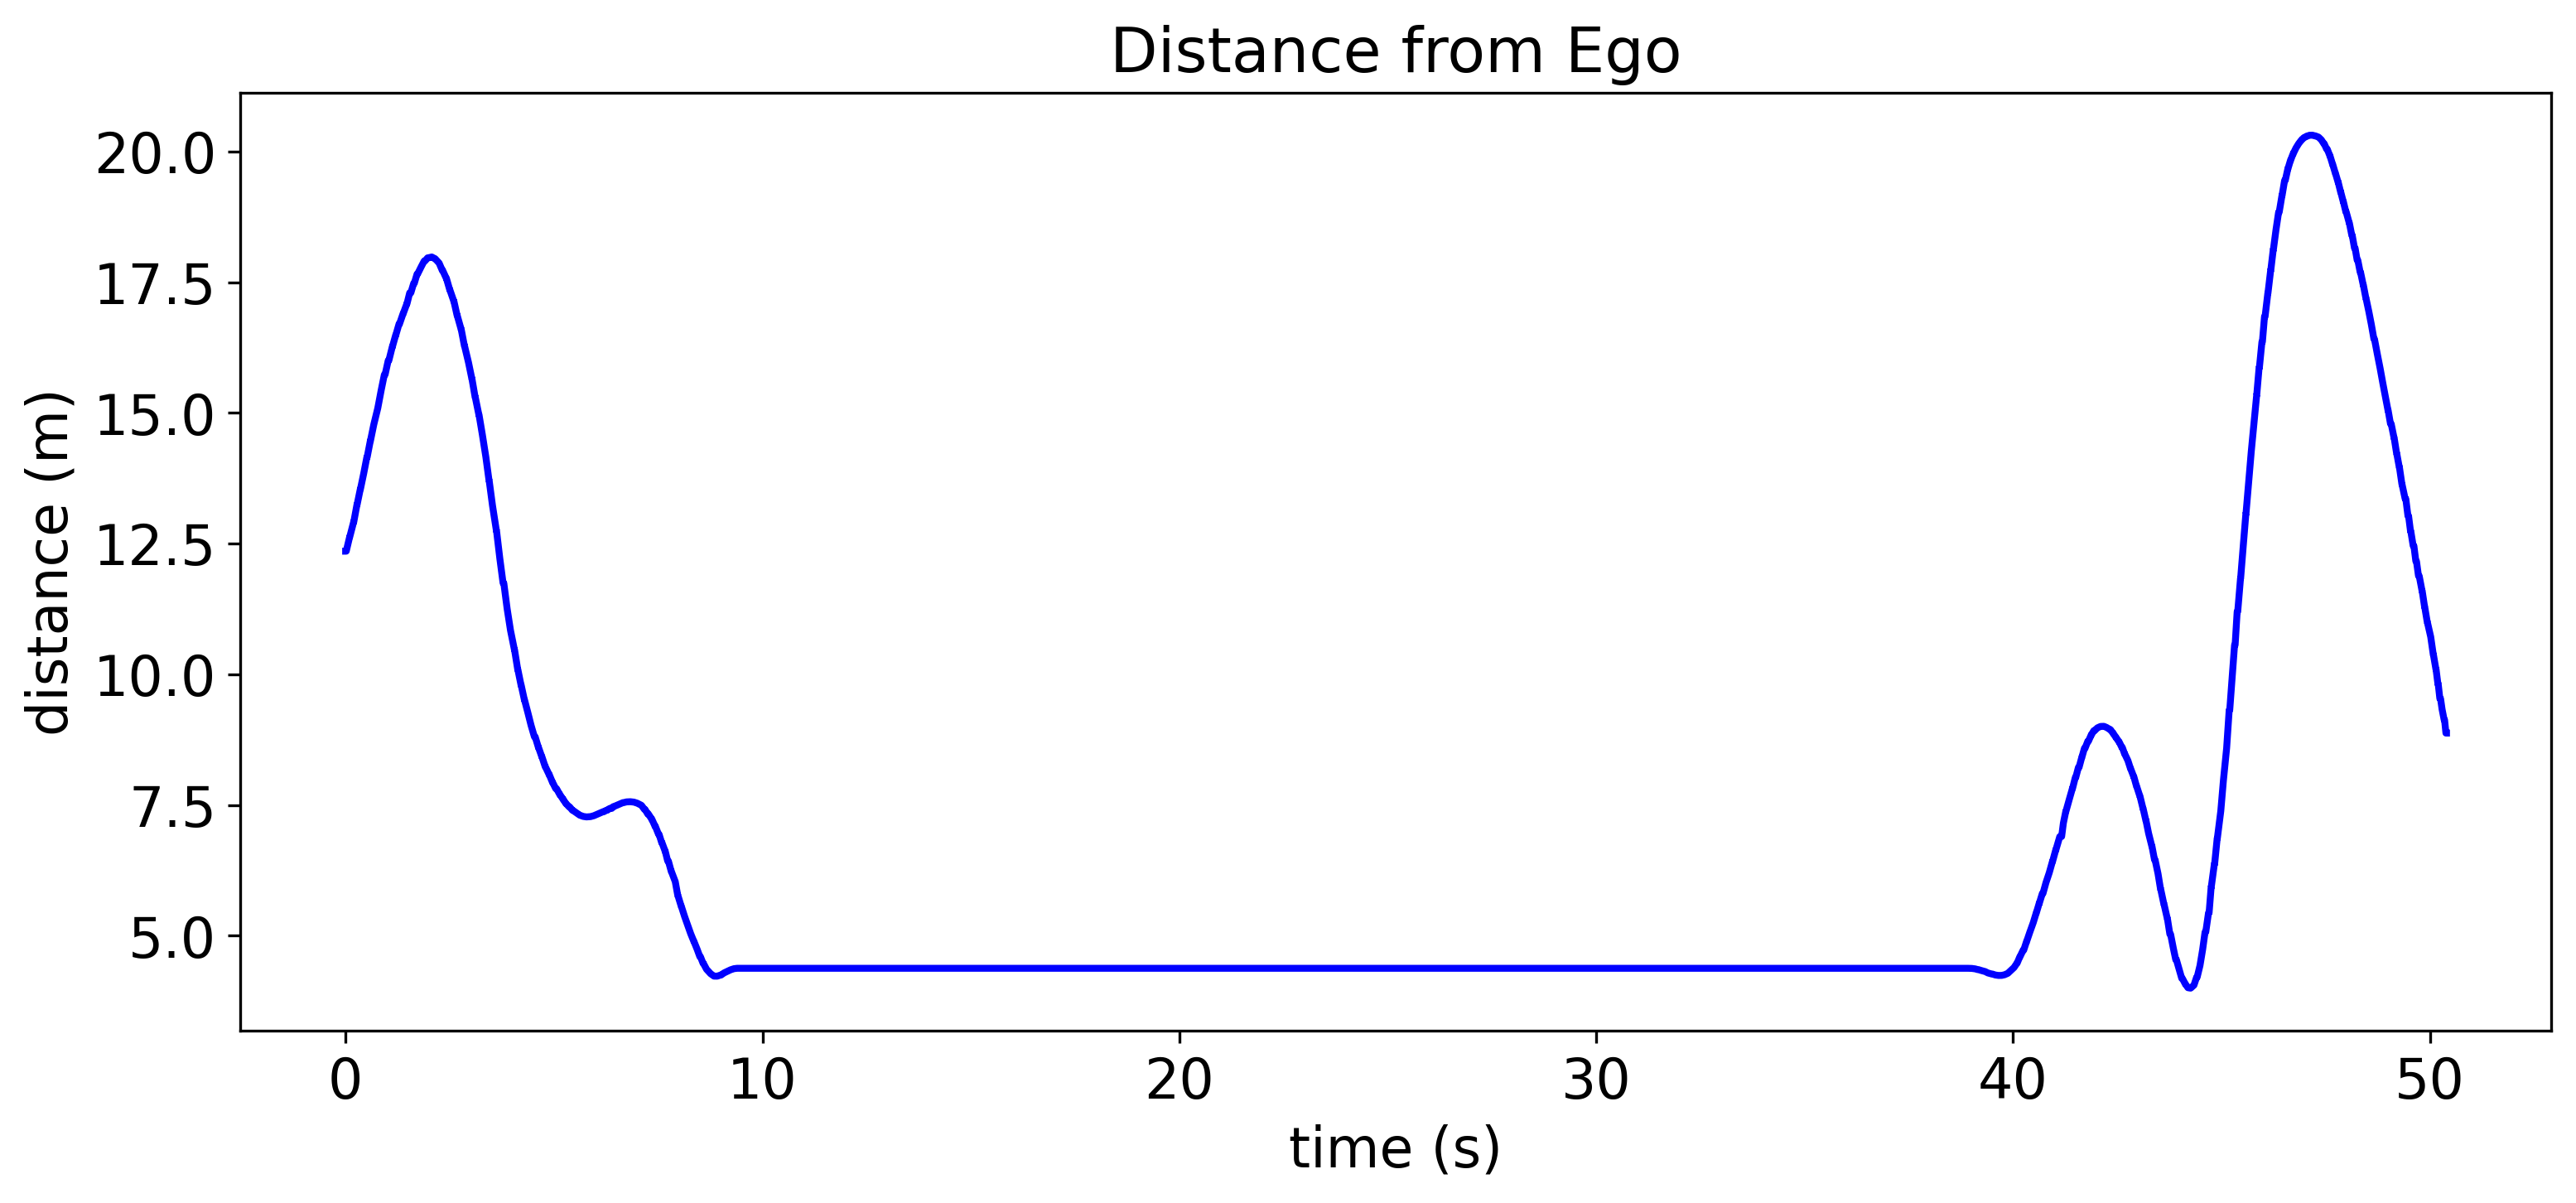

In [7]:
fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

tmp_df = fusion_df.copy()

tmp_df['distance'] = np.hypot(fusion_df['x'], fusion_df['y'])
tmp_df = tmp_df.set_index('timestamp').dropna()

ax.plot(tmp_df['distance'], lw=2, c='b')

ax.set_title('Distance from Ego', fontsize=18)
ax.set_xlabel('time (s)', fontsize=16)
ax.set_ylabel('distance (m)', fontsize=16)
ax.tick_params(labelsize=16)

fig.savefig(f'{EXPERIMENT_NAME}/fusion_layer/{EXPERIMENT_VARIATION}_distance_from_ego.png')

Application DF first measurement: 1621379749483416657


,timestamp,global_list_id,x,y,vx,vy,ax,ay,yaw,yaw_rate,length,width
0,1621379749483416657,1,12.32606,0.85077,3.11015,-0.43930,2.56292,-0.74795,-0.06124,-0.13004,4.18121,1.99412
1,1621379749491055201,2,12.32606,0.85077,3.11015,-0.43930,2.56292,-0.74795,-0.06124,-0.13004,4.18121,1.99412
2,1621379749573371585,3,12.60301,0.79516,3.31587,-0.49978,2.41863,-0.65037,-0.07205,-0.12617,4.18121,1.99412
3,1621379749574499893,4,12.60301,0.79516,3.31587,-0.49978,2.41863,-0.65037,-0.07205,-0.12617,4.18121,1.99412
4,1621379749668667644,5,12.89532,0.70732,3.46177,-0.63282,1.73338,-1.42841,-0.08512,-0.16696,4.18121,1.99412


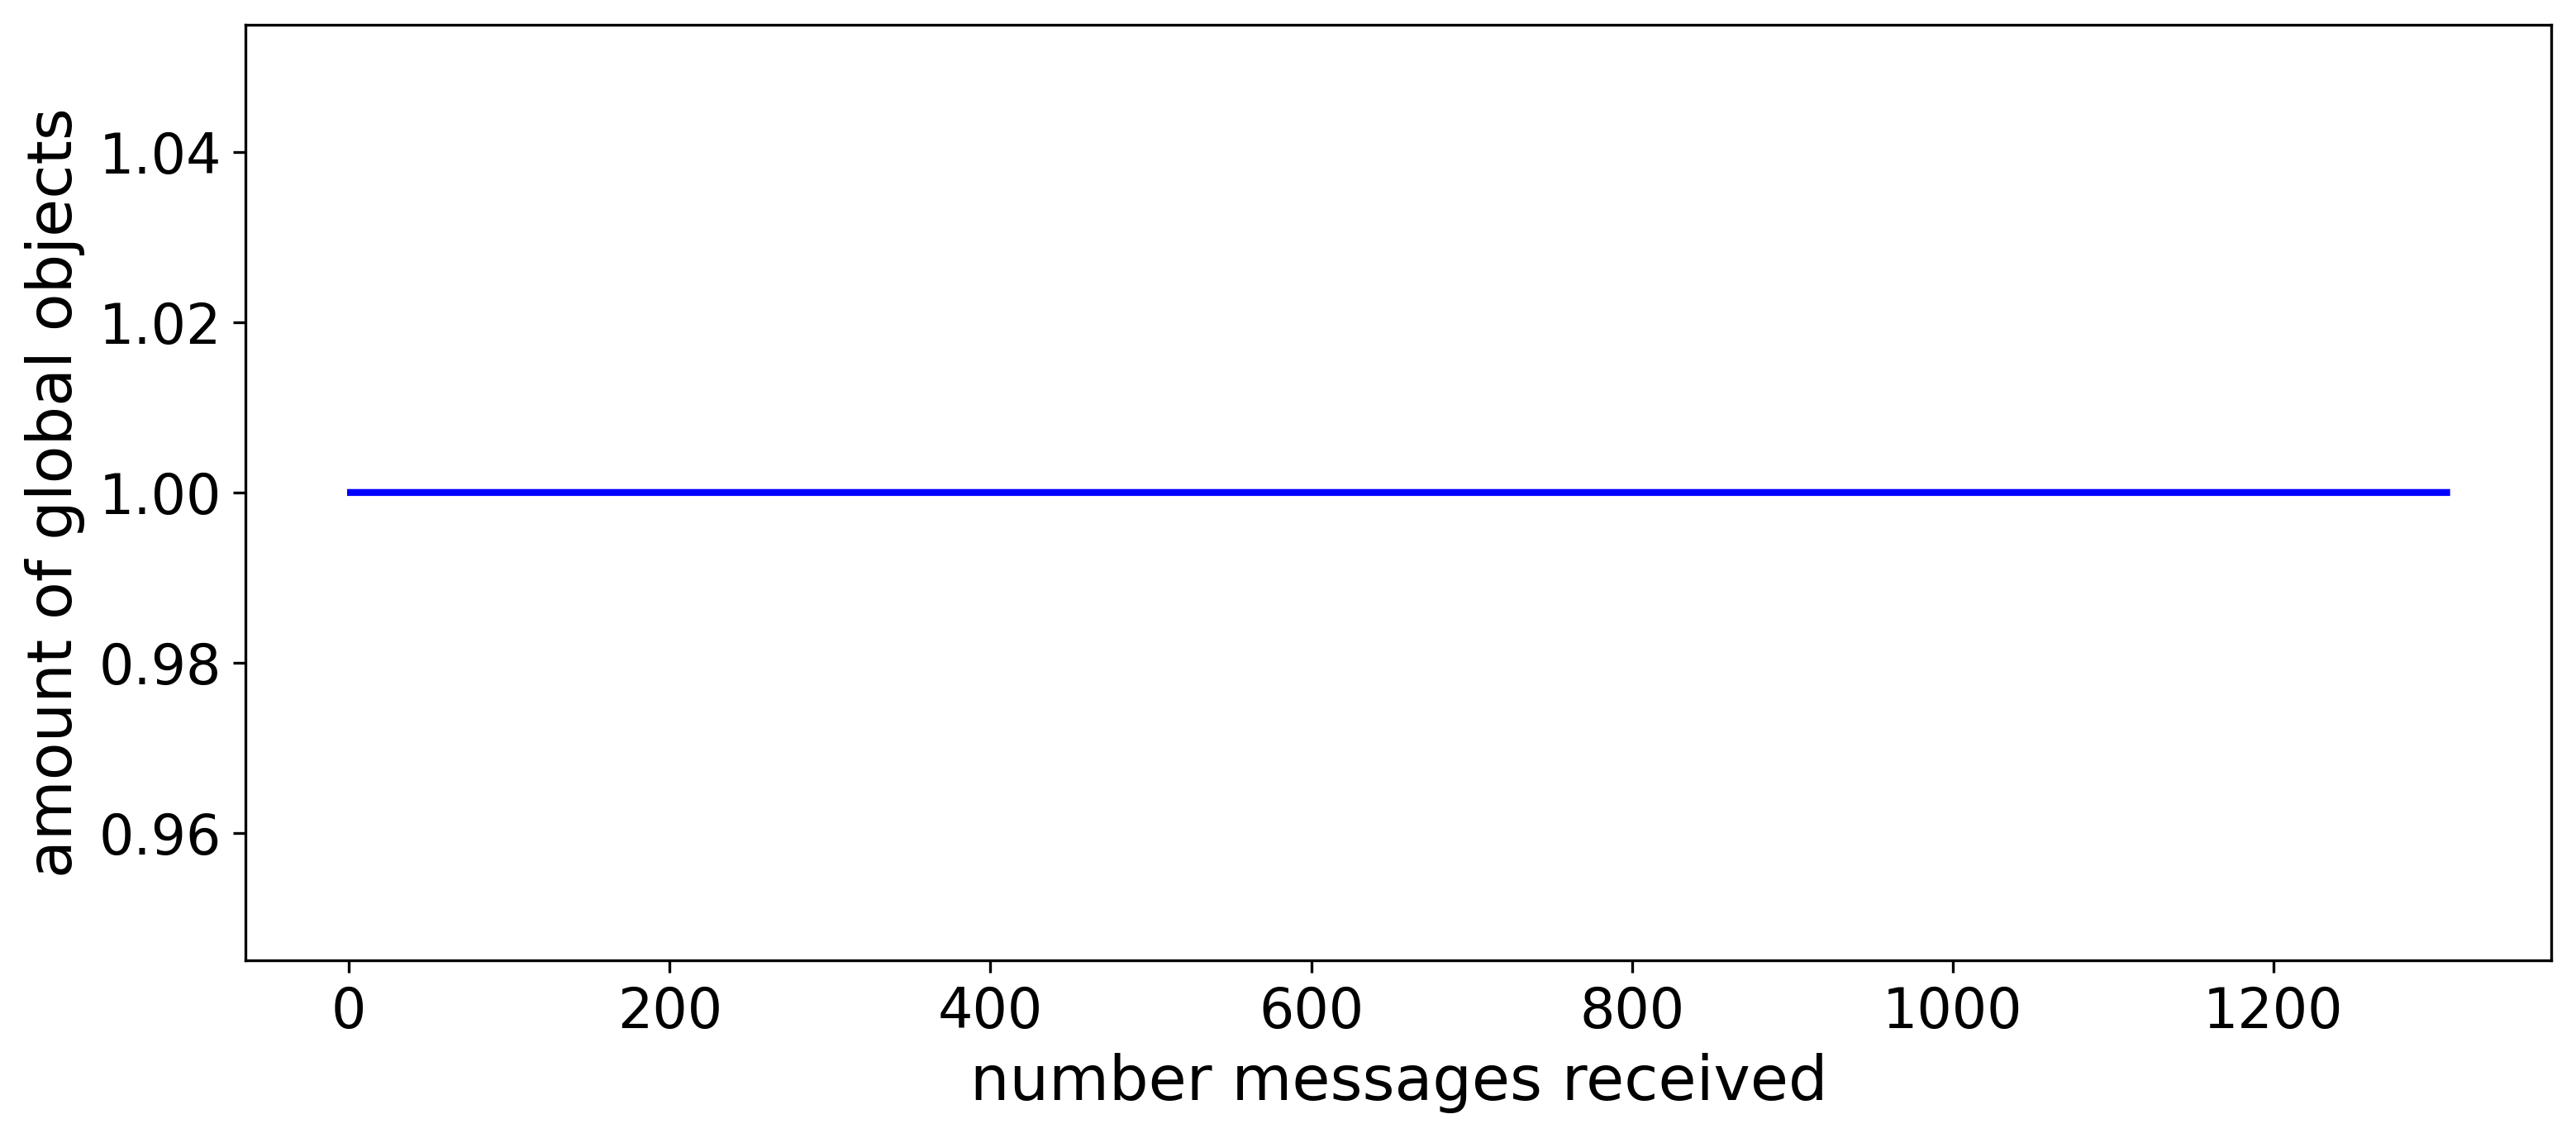

In [8]:
application_df_file = EXPERIMENT_FILES['application_layer'][EXPERIMENT_VARIATION]
application_df = pd.read_csv(
    application_df_file,
    names=['timestamp', 'global_list_id', 'x', 'y', 'vx', 'vy', 'ax', 'ay', 'yaw', 'yaw_rate', 'length', 'width']
)

print('Application DF first measurement:', application_df['timestamp'].min())

fig, ax = plt.subplots(figsize=(12, 5), dpi=300)

amount_objs = application_df.groupby('global_list_id')['timestamp'].count()

ax.plot(amount_objs, lw=2, c='b')
ax.set_xlabel('number messages received', fontsize=18)
ax.set_ylabel('amount of global objects', fontsize=18)
ax.tick_params(labelsize=16)

fig.savefig(f'{EXPERIMENT_NAME}/application_layer/{EXPERIMENT_VARIATION}_amount_global_objs.png')

application_df.head()

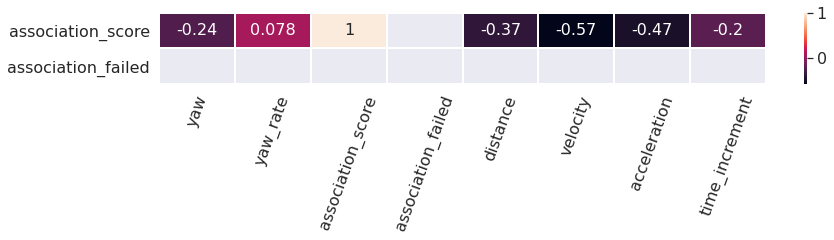

In [9]:
import seaborn as sns

sns.set_theme()

tmp_df = fusion_df.copy()
# tmp_df = tmp_df[tmp_df.timestamp > 40]  # Useful for both moving but without temporal alignment

fig, ax = plt.subplots(figsize=(13, 3.5))

pd.set_option('mode.chained_assignment', None)  # Just disabling assignment warning

tmp_df['distance'] = np.hypot(fusion_df['x'], fusion_df['y'])
tmp_df['velocity'] = np.hypot(fusion_df['vx'], fusion_df['vy'])
tmp_df['acceleration'] = np.hypot(fusion_df['ax'], fusion_df['ay'])
tmp_df['time_increment'] = tmp_df['timestamp'].diff()
tmp_df = tmp_df.dropna()

tmp_df = tmp_df.set_index('timestamp').drop(['idx_to_associate', 'x', 'y', 'vx', 'vy', 'ax', 'ay'], axis=1)

correlation = tmp_df.corr()
correlation = correlation.loc[['association_score', 'association_failed']]
sns.heatmap(correlation, annot=True, linewidths=1, annot_kws={"fontsize":16})

ax.tick_params(labelsize=16)
ax.set_xticklabels(ax.get_xticklabels(), rotation=70)
cbar = ax.collections[0].colorbar
cbar.ax.tick_params(labelsize=16)
plt.tight_layout()

plt.show()
fig.savefig(f'{EXPERIMENT_NAME}/fusion_layer/{EXPERIMENT_VARIATION}_error_correlation.png')

In [10]:
duration = fusion_df['timestamp'].max()

print('Number of object measurements:', fusion_df.shape[0])
print('Number of errors:', fusion_df[fusion_df.association_failed == 1.0].shape[0] - 1)
print('Mean Server FPS:', fusion_df.shape[0]/duration)
print('Global Objects at the end:', amount_objs.max())
print('Duration:', duration)
print('Maximum relative velocity magnitude', np.hypot(fusion_df['vx'], fusion_df['vy']).max())

fusion_df.tail()

Number of object measurements: 1308
Number of errors: 0
Mean Server FPS: 25.953920621860597
Global Objects at the end: 1
Duration: 50.397010111
Maximum relative velocity magnitude 10.988070910805954


,timestamp,sensor_name,x,y,vx,vy,ax,ay,yaw,yaw_rate,idx_to_associate,association_score,association_failed
1303,50.290821,sensor2,-9.23382,1.35811,4.66251,0.08160,0.94978,0.00020,0.01216,0.00003,0,0.995,0
1304,50.341096,sensor1,-9.02638,1.36170,4.70426,0.08161,0.94335,0.00023,0.01216,0.00003,0,0.972,0
1305,50.351182,sensor2,-9.02638,1.36170,4.70426,0.08161,0.94335,0.00023,0.01216,0.00003,0,0.953,0
1306,50.383584,sensor1,-8.77087,1.36612,4.75451,0.08162,0.93104,0.00024,0.01217,0.00003,0,0.901,0
1307,50.397010,sensor2,-8.77087,1.36612,4.75451,0.08162,0.93104,0.00024,0.01217,0.00003,0,0.937,0
